In [1]:
'''
Waterfowl energetics model
October 2023
Mike Mitchell - mmitchell@ducks.org - Ducks Unlimited

Methods

Duckdb

'''
baseaoiurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/'
aois = ['ARmav', 'ARwg', 'KY', 'LAmav', 'LAwg', 'MO', 'MS', 'OK', 'TN', 'TX'] # used to read in files. example: baseaoiurl+aoi+'daily_obj3.csv'

# Habitat curve should be in percentages and max shouldn't be more than 100.
cropcurvedata = {
                    'EmergentWetlands':[19,89,100],
                    'WoodyWetlands':[2,89,100],
                    'OpenWater':[100,100,100],
                    'Sorghum':[3,100,30],
                    'Corn':[3,100,27],
                    'Soybeans':[5,100,38],
                    'Rice':[9,100,39],
                    'Aquaculture':[34,94,100],
                    'Millet':[46,100,95],
                    'Dbl Crop Corn/Soybeans':[2,100,28]
                }

energycsvurl = 'https://giscog.blob.core.windows.net/waterfowlmodel/4D_LMVJV-ST_Obj_FINAL_LONG2.csv'

In [2]:
# Changing minimum crop to 20%
'''
minval = 100
for k,v in cropcurvedata.items():
    for i in v:
        if i < minval:
            v[v.index(i)] = minval
'''

'\nminval = 100\nfor k,v in cropcurvedata.items():\n    for i in v:\n        if i < minval:\n            v[v.index(i)] = minval\n'

In [3]:
##########################################
# All config above this line
##########################################

In [4]:
# Checks to make sure habitat curves have at least 3 values and they are not > 100%        
for key,val in cropcurvedata.items():
    if max(val) >100:
        print('Value in {} has a value greater than 100'.format(key))
    if len(val) <3:
        print('Not a great curve with < 3 values for {}'.format(key))            

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import pandas as pd
import json, requests
import geopandas as gpd
import shapely
import duckdb
from shapely import wkt, wkb
#import pygeos as pg

#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x : "{:,.2f}".format(x))

In [6]:
con = duckdb.connect()
con.install_extension("spatial")
con.load_extension("spatial")
con.install_extension("azure")
con.load_extension("azure")

In [7]:
##########################################
#
# Run everything above this
#
##########################################

In [8]:
con.sql('''
CREATE OR REPLACE TABLE lmvjvwaterfowlenergy AS SELECT * FROM read_parquet('D:\source\waterfowlenergynotebook\lmvjvwaterfowlenergy.parquet')
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
aoiquery = 'https://services2.arcgis.com/5I7u4SJE1vUr79JC/ArcGIS/rest/services/LMVJV_Boundary/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
r = json.dumps(requests.get(aoiquery).json())
aoiresult = gpd.read_file(r)

aoibounds = list(aoiresult.bounds.values[0])
incounty = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Counties/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
r = json.dumps(requests.get(incounty).json())
county = gpd.read_file(r)
county = county[['FIPS','NAME', 'STATE_NAME', 'geometry']]

instate = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Enriched_USA_States_Generalized_Boundaries/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry={0}&geometryType=esriGeometryEnvelope&inSR=5070&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=5070&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='.format(', '.join(str(a) for a in aoibounds))
r = json.dumps(requests.get(instate).json())
state = gpd.read_file(r)

inbcr = 'https://gisweb.ducks.org/server/rest/services/GEODATA/BCR/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=5070&havingClause=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnExceededLimitFeatures=false&quantizationParameters=&returnCentroid=false&timeReferenceUnknownClient=false&sqlFormat=none&resultType=&featureEncoding=esriDefault&datumTransformation=&f=geojson'
r = json.dumps(requests.get(inbcr).json())
bcr = gpd.read_file(r)

In [10]:
county['geometry'] = county.to_wkt().geometry
bcr['geometry'] = bcr.to_wkb().geometry

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_25460\4166743715.py:1: UserWarning: Geometry column does not contain geometry.
  county['geometry'] = county.to_wkt().geometry
C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_25460\4166743715.py:2: UserWarning: Geometry column does not contain geometry.
  bcr['geometry'] = bcr.to_wkb().geometry


In [11]:
county.columns

Index(['FIPS', 'NAME', 'STATE_NAME', 'geometry'], dtype='object')

In [13]:
con.sql('''CREATE OR REPLACE TABLE cnty AS SELECT * EXCLUDE geometry, ST_GeomFromText(geometry) AS geometry FROM county''')

In [14]:
con.sql('''CREATE OR REPLACE TABLE cnty AS SELECT FIPS, NAME, STATE_NAME, geometry FROM cnty''')

In [18]:
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT * EXCLUDE geometry, st_geomfromWKB(geometry) as geometry FROM bcr''')
con.sql('''CREATE OR REPLACE TABLE bcr AS SELECT BCR, BCRNAME, geometry FROM bcr''')

In [19]:
con.sql('''CREATE OR REPLACE TABLE statebcr AS 
SELECT NAME, FIPS, STATE_NAME, BCR, BCRNAME, ST_Intersection(cnty.geometry, bcr.geometry) as geometry
FROM cnty
JOIN
bcr ON ST_Intersects(cnty.geometry, bcr.geometry)
''')


In [20]:
con.sql(
    """
        CREATE OR REPLACE TABLE statebcrenergy AS 
        SELECT c.FIPS, c.NAME, c.STATE_NAME, c.BCR, c.BCRNAME, e.CLASS, e.ValueLo, e.ValueHi, ST_Intersection(ST_GeomFromWKB(e.geometry), c.geometry) as geometry
        FROM lmvjvwaterfowlenergy AS e, statebcr AS c
        WHERE ST_Intersects(ST_GeomFromWKB(e.geometry), c.geometry)
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [21]:
##################################################
#
# Continue
#
##################################################
duckdb.__version__

'0.9.2'

In [22]:
# Read in energy layer
#gdf.to_parquet('energylayerintersect.parquet')
inenergy = con.sql('select * exclude geometry, ST_AsText(geometry) as geometry from statebcrenergy').df()
inenergy['geometry'] = inenergy['geometry'].apply(wkt.loads)
inenergy = gpd.GeoDataFrame(inenergy, geometry='geometry', crs=5070)
inenergy.head()

,FIPS,NAME,STATE_NAME,BCR,BCRNAME,Class,ValueLo,ValueHi,geometry
0,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((421575.000 1402185.000, 421575.000 1..."
1,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Herbaceous Wetlands,247,1622,"POLYGON ((422865.000 1402215.000, 422895.000 1..."
2,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((428355.000 1402215.000, 428355.596 1..."
3,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437325.000 1402214.299, 437325.000 1..."
4,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437385.000 1402214.299, 437385.000 1..."


In [23]:
inenergy = inenergy.rename(columns={'Class':'CLASS'})
inenergy.head()

,FIPS,NAME,STATE_NAME,BCR,BCRNAME,CLASS,ValueLo,ValueHi,geometry
0,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((421575.000 1402185.000, 421575.000 1..."
1,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Herbaceous Wetlands,247,1622,"POLYGON ((422865.000 1402215.000, 422895.000 1..."
2,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Woody Wetlands,122,221,"POLYGON ((428355.000 1402215.000, 428355.596 1..."
3,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437325.000 1402214.299, 437325.000 1..."
4,05067,Jackson County,Arkansas,26,MISSISSIPPI ALLUVIAL VALLEY,Soybeans,937,3410,"POLYGON ((437385.000 1402214.299, 437385.000 1..."


In [24]:
'''
Prep energy layer so we can calculate total energy at the county level.  Remove NAN
'''
#inenergy = inenergy.set_crs(5070)
inenergy['acres'] = inenergy.area* 0.000247105
inenergy.loc[inenergy.CLASS=='Woody Wetlands', ['CLASS']] = 'WoodyWetlands'
inenergy.loc[inenergy.CLASS=='Open Water', ['CLASS']] = 'OpenWater'
inenergy.loc[inenergy.CLASS=='Herbaceous Wetlands', ['CLASS']] = 'EmergentWetlands'
inenergy = inenergy.drop(['geometry'], axis=1)
inenergy = inenergy.groupby(['FIPS','NAME','STATE_NAME','BCR','BCRNAME','CLASS','ValueLo','ValueHi']).sum()
inenergy = inenergy.reset_index()
inenergy = inenergy[inenergy['NAME']!='NaN']
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Arkansas_wg'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Louisiana_mav'
inenergy.loc[(inenergy['STATE_NAME']=='Louisiana') & (inenergy['BCRNAME']=='WEST GULF COASTAL PLAIN/OUACHITAS'), ['statebcr']] = 'Louisiana_wg'
inenergy.loc[~inenergy['STATE_NAME'].isin(['Arkansas', 'Louisiana']), ['statebcr']] = inenergy['STATE_NAME']
inenergy = inenergy.drop(['FIPS','NAME','STATE_NAME','BCR','BCRNAME'], axis=1)

C:\Users\mmitchell.DUCKS\AppData\Local\Temp\ipykernel_25460\161467790.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Arkansas_mav' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inenergy.loc[(inenergy['STATE_NAME']=='Arkansas') & (inenergy['BCRNAME']=='MISSISSIPPI ALLUVIAL VALLEY'), ['statebcr']] = 'Arkansas_mav'


In [25]:
print('Habitat acres: {0:,.0f}'.format(inenergy['acres'].sum()))
print('DEDs: {0:,.0f}'.format((inenergy['acres']*inenergy['ValueHi']).sum()))

Habitat acres: 6,758,185
DEDs: 16,275,689,198


In [26]:
# Read population objectives
popobjtable = pd.read_csv(energycsvurl)
popobjtable = popobjtable.rename(columns={'State':'state', 'LMVJV.80P.OBJ':'popobj80'})
print('Max population objective: {0:,.0f}'.format(popobjtable['popobj80'].max()))

Max population objective: 2,672,079


In [27]:
# Read waterfowl curves and adjust attributes to align with long term objectives by statebcr
mergecurve = pd.DataFrame()
for aoi in aois:
    incsv = pd.read_csv(baseaoiurl+aoi+'daily_obj3.csv')
    mergecurve = pd.concat([mergecurve, incsv])
mergecurve = mergecurve.rename(columns={'ST':'state','SP2':'species'})
mergecurve.loc[mergecurve.state=='ARmav', ['state']] = 'Arkansas_mav'
mergecurve.loc[mergecurve.state=='ARwg', ['state']] = 'Arkansas_wg'
mergecurve.loc[mergecurve.state=='KY', ['state']] = 'Kentucky'
mergecurve.loc[mergecurve.state=='LAwg', ['state']] = 'Louisiana_wg'
mergecurve.loc[mergecurve.state=='LAmav', ['state']] = 'Louisiana_mav'
mergecurve.loc[mergecurve.state=='MO', ['state']] = 'Missouri'
mergecurve.loc[mergecurve.state=='MS', ['state']] = 'Mississippi'
mergecurve.loc[mergecurve.state=='OK', ['state']] = 'Oklahoma'
mergecurve.loc[mergecurve.state=='TN', ['state']] = 'Tennessee'
mergecurve.loc[mergecurve.state=='TX', ['state']] = 'Texas'

In [71]:
# Merge population objectives and waterfowl curves.  Scale curves so the population objective is the max on the curve.
curvetable = pd.merge(mergecurve, popobjtable, on=('state', 'species'), how='left')

In [72]:
curvetable['max'] = curvetable.select_dtypes(include=[np.float64]).drop(columns=['popobj80']).max(axis=1)
curvetable = curvetable[curvetable['popobj80']>0]
curvetable['scale'] = curvetable['popobj80']/curvetable['max']
newtable = curvetable[curvetable.select_dtypes(include=['float64']).columns].multiply(curvetable['scale'],axis='index')
newtable = newtable.drop(columns=['popobj80', 'max', 'scale'])
curvetable.update(newtable)

In [73]:
curvetable = curvetable.drop(columns=['max', 'scale', 'popobj80'])
curvetable = curvetable.rename(columns={'state':'statebcr'})

In [74]:
# Read in decomp
incover = pd.read_csv(baseaoiurl+'cover_values.csv')
incover = incover[['COVER', 'DECOMP']].rename(columns={'COVER':'CLASS', 'DECOMP':'decomp'})

In [75]:
# Read basal metabolic rates by species
#inbmr = pd.read_csv(baseaoiurl+'RMR_BMR.csv')
#inbmr = inbmr[['Species', 'BMR (kcal)']].rename(columns={'Species':'species', 'BMR (kcal)':'bmr'})

In [77]:
# Merge population objectives / waterfowl curves with metabolic rates
#curvetable = pd.merge(curvetable, inbmr, on=('species'), how='left')
# Change curvetable to be kcal curve that takes into account bmr and popobj
#newtable = curvetable[curvetable.select_dtypes(include=['float64']).columns].multiply(curvetable['bmr'],axis='index')
#newtable = newtable.drop(columns=['bmr'])
#curvetable.update(newtable)
#curvetable = curvetable.drop(columns=['bmr'])

AGWT: 780,489
AMWI: 308,854
BWTE: 45,817
CANV: 141,576
GADW: 1,101,470
MALL: 3,900,517
NOPI: 987,018
NSHO: 949,935
REDH: 67,157
RNDU: 322,654
SCAU: inf
WODU: 1,372,989


Text(0.5, 1.0, 'Species curves')

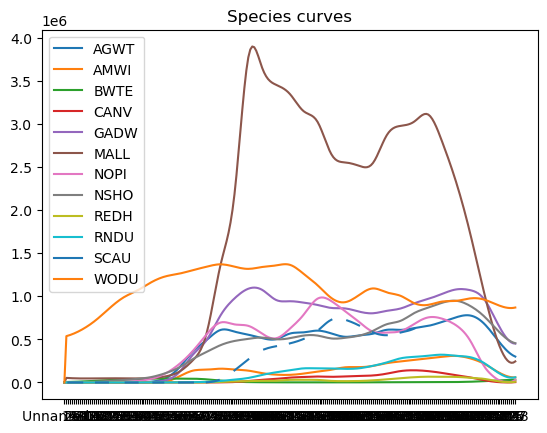

In [78]:
# Plot by species
i=0
for sp in curvetable['species'].unique():
    tmp = curvetable.groupby('species').sum().drop(columns='statebcr')
    tmp = tmp.reset_index()
    tmp = tmp[tmp['species']==sp]
    tmp = tmp.drop(['species'], axis=1).transpose().reset_index()
    plt.plot(tmp['index'],tmp[i])
    print("{0}: {1:,.0f}".format(sp, max(tmp[i])))
    i+=1
plt.legend(curvetable['species'].unique())
plt.title('Species curves')

In [80]:
curvetable = curvetable.groupby(['statebcr']).sum().reset_index().drop(['Unnamed: 0'], axis=1)

In [82]:
curvetable = curvetable.drop(columns='species')
#curvetable[(curvetable['statebcr']=='Arkansas_mav')].drop(columns=['statebcr']).transpose().max()

Text(0.5, 1.0, 'Demand by statebcr')

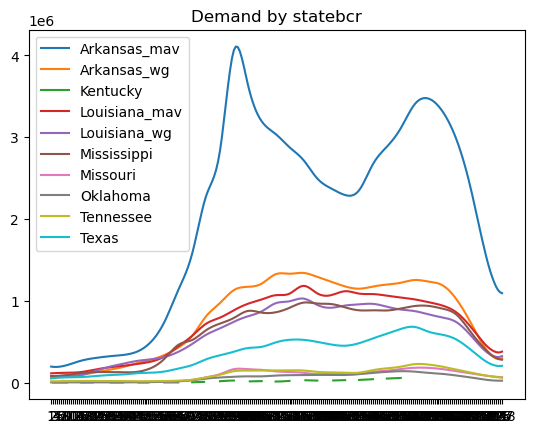

In [83]:
# sum energy demand by statebcr, removing species.
#display(curvetable.head())
i=0
for st in curvetable['statebcr'].unique():
    query = pd.DataFrame(curvetable[curvetable['statebcr']==st]).drop('statebcr',axis=1).transpose().reset_index()
    plt.plot(query['index'], query[i])
    i+=1
plt.legend(curvetable['statebcr'].unique())    
plt.title('Demand by statebcr')

Index(['index', 0], dtype='object')


Text(0.5, 1.0, 'Demand')

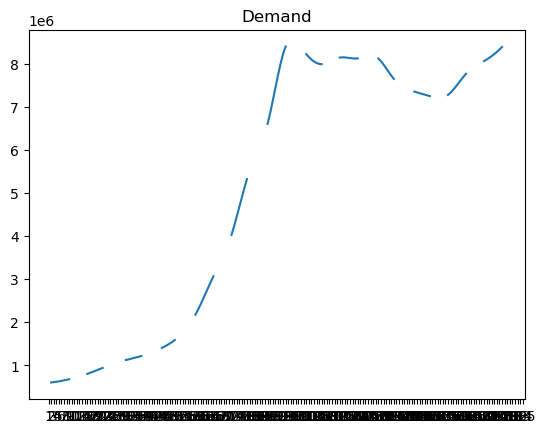

In [84]:
totaldemand = curvetable.sum().reset_index().drop([0])
print(totaldemand.columns)
plt.plot(totaldemand['index'], totaldemand[0])
plt.title('Demand')

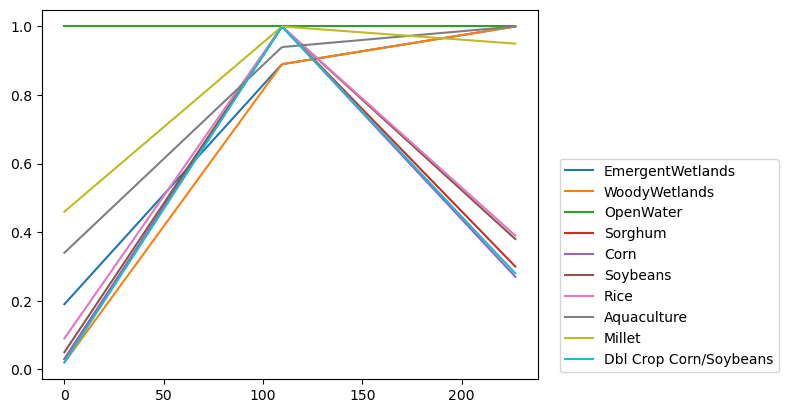

In [86]:
# Calculate habitat curves
habitatcurvedata = {}
for sp in cropcurvedata.keys():
    habitatcurvedata[sp] = np.interp(np.linspace(0, 228, 228), [0,110,228], cropcurvedata[sp])
    if max(habitatcurvedata[sp]) > 1:
        habitatcurvedata[sp] = habitatcurvedata[sp]/100
habitatcurve = pd.DataFrame.from_dict(habitatcurvedata).transpose().reset_index().rename(columns={'index':'CLASS'})
for sp in cropcurvedata.keys():
    model = habitatcurvedata[sp]
    plt.plot(model, label=sp)
    plt.legend(loc='lower right',bbox_to_anchor=(1.5, 0))

In [90]:
'''
Iterate through days where each day is a column in the curve tables.
    At each day calculate supply and demand
    Example
        Day 35
            Supply = ex:500, day 35 on curve provides X value multiplied by the energy for that value (both high and low)
            Demand = ex:300, day 35 on curve for Species N multiplied by the demand of that species.
            Available = ex: 200, Supply - demand but can't drop below 0.
        Day 36
            Supply = ex: 600, day 36.
            Supply = ex: 200 + (600-500)= 300 , available from the day before + (supply on day 36 - supply on day 35)
            Demand = ex: 400, day 36
            Available = 300 (calculated based on available from day 35 and supply today) - demand today of 400 = -100 or 0
'''
trackenergy = pd.DataFrame() # create empty dataframe to hold output by day
energylayer = inenergy.copy()
energylayer['unique'] = energylayer.index
energylayer['vegenergyprevLo'] = 0
energylayer['vegenergyprevHi'] = 0

#trackenergy = trackenergy.append(energylayer) # Add day 0 to temporal result tracking
trackhideficit = pd.DataFrame()#[]
tracklodeficit = pd.DataFrame()#[]
for i in range(1,228): #1 to 228
    #print('Day: {}'.format(i))
    
    #supply
    '''
    Supply is the energy provided by a habitat type.  The amount of habitat available changes daily.  Each crop has it's own energy value.
    Sum of (energy value of specific crop * acres available on that day) by bcrstate = energy supply
    '''
    energylayer['day'] = i
    hab = habitatcurve[['CLASS', i]] # select habitat availability curve for day by class
    energylayer = energylayer.merge(hab, on='CLASS', how='left') # merge habitat curve to the energy layer
    energylayer['habpct'] = energylayer[i]
    energylayer = energylayer.drop(i, axis=1)
    energylayer['availacres']= energylayer['acres'] * energylayer['habpct']# calculate available acres which is acres of the energy polygon * habitat type availability for that day.
    energylayer['vegenergyLo'] = energylayer['availacres'] * energylayer['ValueLo']
    energylayer['vegenergyHi'] = energylayer['availacres'] * energylayer['ValueHi']
    energylayer['supplyLo'] = energylayer['vegenergyLo'] - energylayer['vegenergyprevLo'] # Energy supply includes the leftover energy from the day before plus the difference between todays supply energy and yesterdays.
    energylayer['supplyHi'] = energylayer['vegenergyHi'] - energylayer['vegenergyprevHi']
    energylayer['vegenergyprevLo'] = energylayer['vegenergyLo']
    energylayer['vegenergyprevHi'] = energylayer['vegenergyHi']
    # supply can't be less than 0
    energylayer.loc[energylayer['supplyLo']<0,['supplyLo']] = 0
    energylayer.loc[energylayer['supplyHi']<0,['supplyHi']] = 0
    
    #demand
    # Sum energy to the statebcr
    supplybcr = energylayer[['supplyLo','supplyHi','statebcr']].groupby(['statebcr']).sum().reset_index() # Calculate total energy supply by statebcr

    # population curve
    popcurve = curvetable[['statebcr', str(i)]] # select demand for the day based on curve.
    tmp = supplybcr.merge(popcurve, on='statebcr', how='left') # merge demand for that day based on statebcr
    supplybcr['demand'] = tmp[str(i)]
    supplybcr.loc[(supplybcr['demand']<0)|np.isnan(supplybcr['demand']),['demand']] = 0
    supplybcr['day'] = i
    # remove demand from supply
    if i == 1:
        supplybcr['prevLo'] = 0
        supplybcr['prevHi'] = 0
        supplybcr['leftoverLo'] = supplybcr['supplyLo'] - supplybcr['demand']
        supplybcr['leftoverHi'] = supplybcr['supplyHi'] - supplybcr['demand']
    else:
        tmp = trackenergy[trackenergy['day']==i-1].groupby('statebcr').sum().reset_index()
        tmp = tmp[['statebcr','leftoverLo', 'leftoverHi']]
        tmp = tmp.rename(columns={'leftoverLo':'prevLo', 'leftoverHi':'prevHi'})
        supplybcr = supplybcr.merge(tmp, on='statebcr', how='left')
        supplybcr['leftoverLo'] = supplybcr['prevLo'] + supplybcr['supplyLo'] - supplybcr['demand']
        supplybcr['leftoverHi'] = supplybcr['prevHi'] + supplybcr['supplyHi'] - supplybcr['demand']
    
    tracklodeficit = pd.concat([tracklodeficit,supplybcr[['day','statebcr','leftoverLo']].groupby(['day','statebcr']).sum().reset_index()])
    trackhideficit = pd.concat([trackhideficit,supplybcr[['day','statebcr','leftoverHi']].groupby(['day','statebcr']).sum().reset_index()])
    supplybcr.loc[(supplybcr['leftoverLo']<0)|np.isnan(supplybcr['leftoverLo']),['leftoverLo']] = 0
    supplybcr.loc[(supplybcr['leftoverHi']<0)|np.isnan(supplybcr['leftoverHi']),['leftoverHi']] = 0
    
    trackenergy = pd.concat([trackenergy, supplybcr])

In [91]:
energylayer = inenergy.copy()
i=1
energylayer['day'] = i
hab = habitatcurve[['CLASS', i]] # select habitat availability curve for day by class
energylayer = energylayer.merge(hab, on='CLASS', how='left') # merge habitat curve to the energy layer
energylayer['habpct'] = energylayer[i]
energylayer = energylayer.drop(i, axis=1)
energylayer['availacres']= energylayer['acres'] * 1# calculate available acres which is acres of the energy polygon * habitat type availability for that day.
energylayer['vegenergyLo'] = energylayer['availacres'] * energylayer['ValueLo']
energylayer['vegenergyHi'] = energylayer['availacres'] * energylayer['ValueHi']
energylayer['supplyLo'] = energylayer['vegenergyLo']# Energy supply includes the leftover energy from the day before plus the difference between todays supply energy and yesterdays.
energylayer['supplyHi'] = energylayer['vegenergyHi']

Text(0.5, 1.0, 'Leftover low by statebcr')

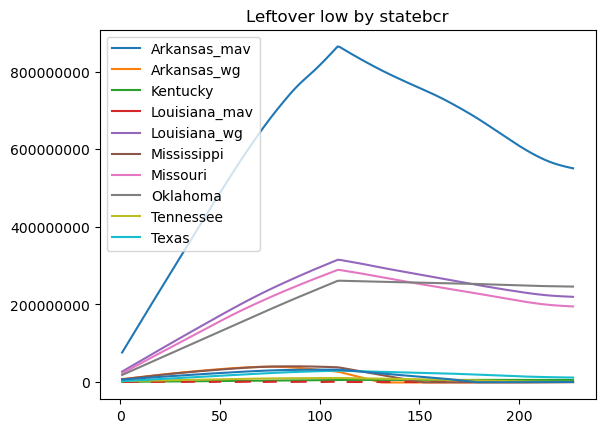

In [92]:
'''
plt.plot(list(range(1,228)),trackhideficit)
plt.plot(list(range(1,228)),tracklodeficit)
plt.title('Energy deficit over time')
plt.legend(['High', 'Low'])
'''
i=0
for st in tracklodeficit['statebcr'].unique():
    query = tracklodeficit[tracklodeficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(query['day'], query['leftoverLo'])
    i+=1
plt.legend(curvetable['statebcr'].unique())
plt.ticklabel_format(style='plain')
plt.title('Leftover low by statebcr')

Text(0.5, 1.0, 'Leftover hi by statebcr')

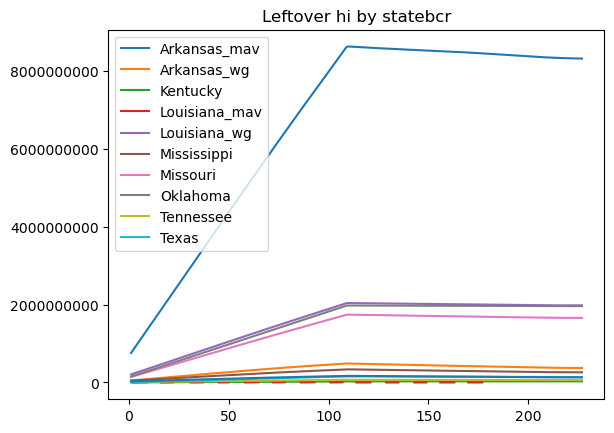

In [93]:
i=0
for st in trackhideficit['statebcr'].unique():
    query = trackhideficit[trackhideficit['statebcr']==st].drop(['statebcr'],axis=1)
    plt.plot(query['day'], query['leftoverHi'])
    i+=1
plt.legend(curvetable['statebcr'].unique())
plt.ticklabel_format(style='plain')
plt.title('Leftover hi by statebcr')

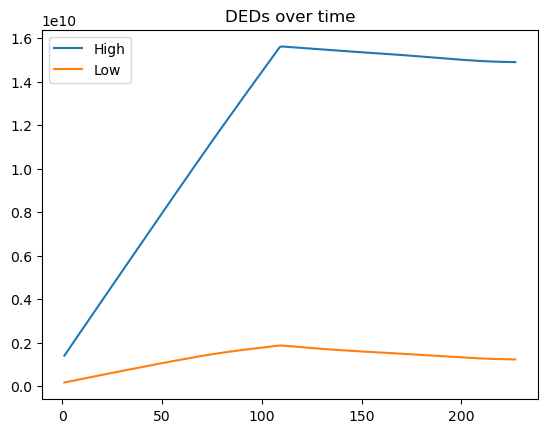

In [94]:
plt.plot(list(range(1,228)),trackenergy[['day','leftoverHi']].groupby(['day']).sum().reset_index()['leftoverHi'])
plt.plot(list(range(1,228)),trackenergy[['day','leftoverLo']].groupby(['day']).sum().reset_index()['leftoverLo'])
plt.title('DEDs over time')
plt.legend(['High', 'Low'])

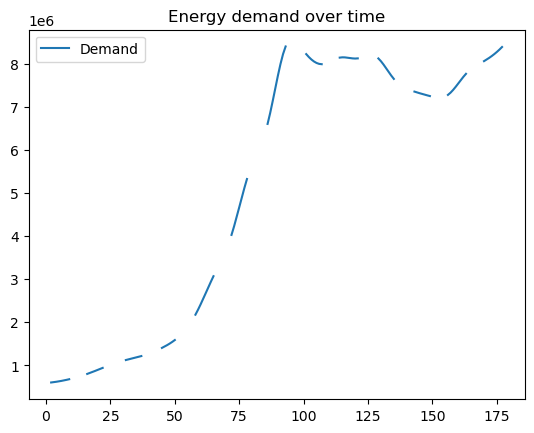

In [95]:
plt.plot(list(range(1,228)),trackenergy[['day','demand']].groupby(['day']).sum().reset_index()['demand'])
plt.title('Energy demand over time')
plt.legend(['Demand'])

In [96]:
energylayer.head()

,CLASS,ValueLo,ValueHi,acres,statebcr,day,habpct,availacres,vegenergyLo,vegenergyHi,supplyLo,supplyHi
0,Aquaculture,3,1954,0.44,Arkansas_mav,1,0.35,0.44,1.33,869.12,1.33,869.12
1,Corn,1130,22530,"3,716.00",Arkansas_mav,1,0.04,"3,716.00","4,199,074.67","83,721,373.74","4,199,074.67","83,721,373.74"
2,EmergentWetlands,247,1622,112.65,Arkansas_mav,1,0.20,112.65,"27,824.80","182,719.97","27,824.80","182,719.97"
3,Millet,0,937,3.11,Arkansas_mav,1,0.46,3.11,0.00,"2,917.37",0.00,"2,917.37"
4,OpenWater,3,3,"14,254.10",Arkansas_mav,1,1.00,"14,254.10","42,762.30","42,762.30","42,762.30","42,762.30"
